In [3]:
import networkx as nx
import json
import gzip
from collections import defaultdict
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


🕸️ Parte 1: Construir la red de retweets
Esto implica:

1. Leer el archivo JSONL

2. Detectar qué tweets son retweets

3. Extraer el usuario original (retuiteado) y el que hizo el retweet

4. Crear un grafo dirigido con esos datos:

Nodo origen: usuario original

Nodo destino: el que retuitea

Si ya hay un enlace, lo puedes acumular como peso (cuántas veces fue retuiteado)

Recordar que:

❌ No debes contar los auto-bucles (un usuario que se retuitea a sí mismo)

✅ Debes asegurarte de tener exactamente 23,343 tweets procesados (ni más ni menos

Se cargaron 23343 tweets.
Se detectaron 14834 retweets.
Ejemplo de pares usuario original → retweeter:
[('Trump_a_right', 'avengingautism'), ('DuckNazi', 'MayorOfFashtown'), ('mrb_rides_again', 'Spectreblackops'), ('mrb_rides_again', 'mohdhm2'), ('VixenRogue', 'PDXGREG')]


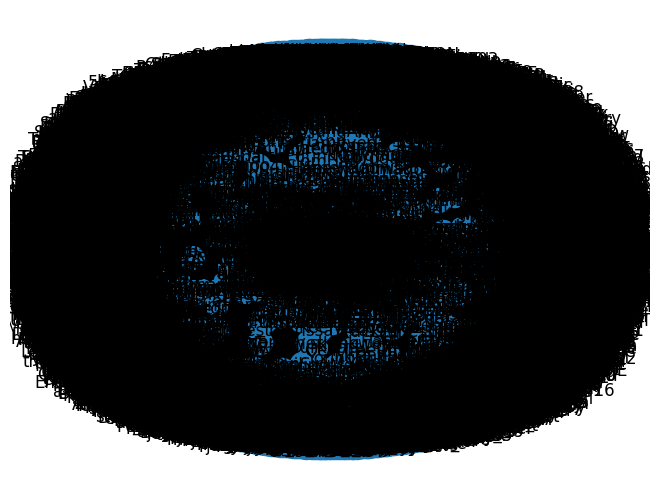

In [4]:
ruta_archivo = 'repealthe19th.jsonl.gz'
datos = []
retweets = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for linea in archivo:
        try:
            tweet = json.loads(linea)
            datos.append(tweet)
            # Detectar si es un retweet
            if "retweeted_status" in tweet:
                original = tweet["retweeted_status"]["user"]["screen_name"]
                retweeter = tweet["user"]["screen_name"]
                
                if original != retweeter:  # evitar auto-bucles
                    retweets.append((original, retweeter))
        except json.JSONDecodeError:
            pass  

print(f"Se cargaron {len(datos)} tweets.")
print(f"Se detectaron {len(retweets)} retweets.")
print("Ejemplo de pares usuario original → retweeter:")
print(retweets[:5])

# Ahora si, crear un grafo dirigido con estos datos
D = nx.DiGraph()
D.add_edges_from(retweets)
nx.draw(D, with_labels=True)



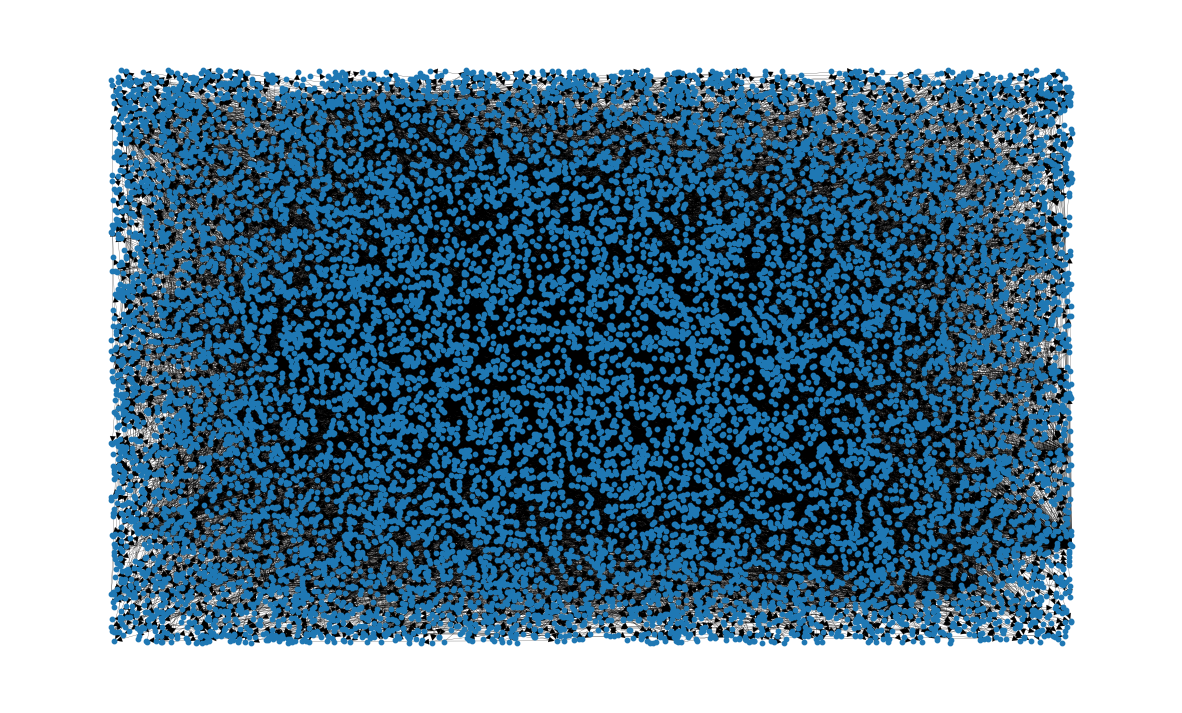

In [5]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(D, pos=nx.random_layout(D), ax=ax, **plot_options)

In [ ]:
pos = nx.spring_layout(D, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(D, pos=pos, ax=ax, **plot_options)

NameError: name 'G' is not defined

In [ ]:
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(D)
net.show('Retweets.html')

Retweets.html


Parte 2: Analizar la red
Con la red ya creada, debes contestar estas preguntas:

1. ¿Cuántos nodos hay?

- Cuántos usuarios únicos participaron (como autores o retuiteadores)

2. ¿Cuántos enlaces hay?

- Cuántas conexiones de retweet hay (dirigidas, sin auto-bucles)

3. ¿Quién fue el más retuiteado?

- El usuario con mayor out-strength (más veces ha sido retuiteado)

4. ¿Y el segundo más retuiteado?

- Igual que arriba, pero segundo lugar.

5. ¿Cuál es el tuit más retuiteado?

- Debes buscar el tuit con más retweets. Su ID está en el campo "id_str"

6. ¿Cuántos usuarios nunca retuitearon?

- Aquellos con out-strength = 0

7. ¿Qué tan conectada está la red?

- Aquí debes analizar si la red está:

- Fuertemente conectada: se puede ir de cualquier nodo a cualquier otro por caminos dirigidos

- Débilmente conectada: se puede ir de cualquier nodo a otro si ignoramos la dirección de los enlaces

- Conectada: similar a lo anterior, pero solo en grafos no dirigidos

- Desconectada: hay nodos o grupos aislados

8. ¿Cuántos nodos hay en el componente débilmente conectado más grande?

- Un componente es un grupo de nodos que están conectados entre sí.

- "Débilmente conectado" significa que al ignorar la dirección de las flechas, están unidos.



### Cuantos nodos hay

In [ ]:
num_nodos = D.number_of_nodes()
print(f"1. Nodos (usuarios únicos): {num_nodos}")


1. Nodos (usuarios únicos): 14862


### ¿Cuántos enlaces (aristas) hay?

In [ ]:
num_aristas = D.number_of_edges()
print(f"2. Enlaces (retweets entre usuarios): {num_aristas}")


2. Enlaces (retweets entre usuarios): 14795


### ¿Quién fue el más retuiteado? (mayor out-strength)
Esto se refiere a cuántas veces alguien fue retuiteado, es decir, cuántas aristas salen de él hacia otros usuarios.

In [ ]:
out_strengths = D.out_degree(weight='weight')
mas_retuiteado = max(out_strengths, key=lambda x: x[1])
print(f"3. Usuario más retuiteado: {mas_retuiteado[0]} → {mas_retuiteado[1]} retweets")


3. Usuario más retuiteado: Samandjunk → 900 retweets


### ¿Y el segundo más retuiteado?

In [ ]:
ordenados = sorted(out_strengths, key=lambda x: x[1], reverse=True)
print(f"4. Segundo más retuiteado: {ordenados[1][0]} → {ordenados[1][1]} retweets")


4. Segundo más retuiteado: m_kaish_esq → 394 retweets


### ¿Cuál es el tuit más retuiteado? (id_str)
Aquí tienes que contar por retweeted_status["id_str"]

In [ ]:
from collections import Counter

id_counter = Counter()

with gzip.open('repealthe19th.jsonl.gz', 'rt', encoding='utf-8') as archivo:
    for linea in archivo:
        tweet = json.loads(linea)
        if "retweeted_status" in tweet:
            original_id = tweet["retweeted_status"]["id_str"]
            id_counter[original_id] += 1

mas_rt = id_counter.most_common(1)[0]
print(f"5. Tweet más retuiteado → ID: {mas_rt[0]} → {mas_rt[1]} retweets")


5. Tweet más retuiteado → ID: 786335044981907456 → 901 retweets


### ¿Cuántos usuarios nunca retuitearon? (out-strength = 0)
Usuarios que nunca hicieron retweet a nadie, solo fueron retuiteados o no interactuaron

In [ ]:
nunca_retuitearon = [n for n in D.nodes() if D.out_degree(n) == 0]
print(f"6. Usuarios que nunca retuitearon: {len(nunca_retuitearon)}")


6. Usuarios que nunca retuitearon: 12916


### ¿Qué tan conectada está la red?

In [ ]:
# a) ¿Fuertemente conectada?
print("7. ¿Fuertemente conectada?", nx.is_strongly_connected(D))

# b) ¿Débilmente conectada?
print("   ¿Débilmente conectada?", nx.is_weakly_connected(D))

# c) Si ninguna de las dos, está desconectada
if not nx.is_weakly_connected(D):
    print("   La red está desconectada.")


7. ¿Fuertemente conectada? False
   ¿Débilmente conectada? False
   La red está desconectada.


### ¿Cuántos nodos hay en el componente débilmente conectado más grande?

In [ ]:
componentes = nx.weakly_connected_components(D)
mayor_componente = max(componentes, key=len)
print(f"8. Nodos en el componente débilmente conectado más grande: {len(mayor_componente)}")


8. Nodos en el componente débilmente conectado más grande: 11909
